<br>
<br>
<center>
    
# 人工智能高阶人才培训班

<br>

> ## 如何用 CNN 实现猫狗识别
</center>
<br>


# 猫🐱-狗🐕分类问题


![](img/cat-dog.jpeg)

> 背景：Kaggle比赛，25，000张训练图像,通过使用深度学习算法，kaggle上目前取得了98%的准确率，我们仅使用8%的数据集，一起来看下效果

在本次实验中，我们将从头开始训练一个CNN的猫狗识别系统。

在本次实验中，我们将遵循人工智能项目的构建流程，按照如下步骤完成实验：
0. 定义问题
1. 了解数据
2. 构建数据工作的pipeline

3. 构建模型

4. 训练模型
5. 评估模型

In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.0.0


## 0. 问题定义

> 猫狗分类实质上是一个二分类问题，输入的是图像数据，输出的是分类的结果

## 1. 数据导入及数据理解

### 下载并获取数据 - cats_and_dogs_filtered.zip
Kaggle 中原始数据可以通过链接 [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) 获取。本实验只使用其一个子集。

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [3]:
base_dir

'/home/iniesa/.keras/datasets/cats_and_dogs_filtered'

### 准备训练数据和验证数据


In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


> 训练样本很平衡

### 创建数据生成器
* 读取数据文件
* jpg文件--> rgb array--> tensor
* 将0-255的像素值缩放到[0, 1]之间
* 图片大小统一到(160,160)
* 数据增强

In [5]:
image_size = 160 # All images will be resized to 64x64
batch_size = 64

In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
         train_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 160x160
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 随机查看一组数据

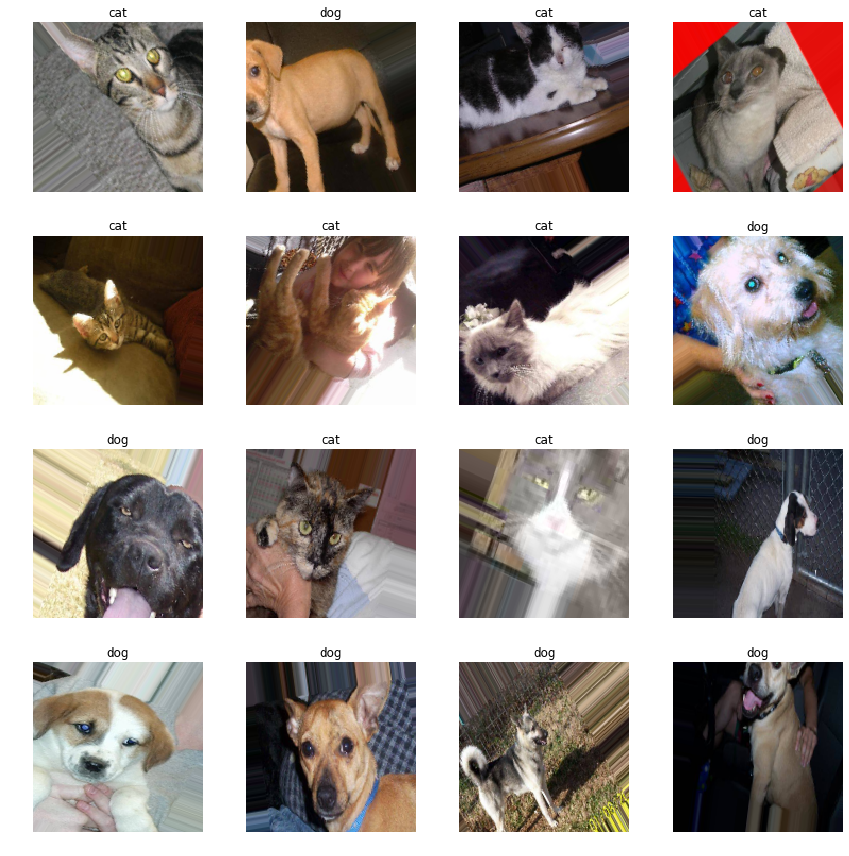

In [7]:
plt.figure(figsize=(12,12))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.axis('off')
        plt.imshow(image)
        label = "dog" if Y_batch[0]==1 else "cat" 
        plt.title(label)
        break
plt.tight_layout()
plt.show()

## 使用DNN模型构建解决该问题的基准模型

在本节中，我们将构建并训练DNN网络。



### 构建模型

In [8]:
IMAGE_SHAPE = (image_size, image_size, 3)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten

model = Sequential(name='CNN_CAT_DOG')


model.add(Conv2D(32,(3,3),activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.1))
# model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "CNN_CAT_DOG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       

### 编译模型
在模型训练之前，通过编译，告诉模型优化目标和优化方法

> 特别注意学习率

In [9]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 模型训练

* 训练100个迭代，我们就已经取得了~85%的准确率；

* 尝试优化提高准确率；

In [10]:

epochs = 50
steps_per_epoch = 100
validation_steps = 100

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/50
100/100 [==============================] - 22s 220ms/step - loss: 0.6938 - accuracy: 0.5166 - val_loss: 0.6926 - val_accuracy: 0.4987
Epoch 2/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6889 - accuracy: 0.5364 - val_loss: 0.6947 - val_accuracy: 0.5078
Epoch 3/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6851 - accuracy: 0.5492 - val_loss: 0.6810 - val_accuracy: 0.5663
Epoch 4/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6473 - accuracy: 0.6321 - val_loss: 0.6332 - val_accuracy: 0.6477
Epoch 5/50
100/100 [==============================] - 19s 190ms/step - loss: 0.6394 - accuracy: 0.6450 - val_loss: 0.6288 - val_accuracy: 0.6378
Epoch 6/50
100/100 [==============================] - 19s 187ms/step - loss: 0.6179 - accuracy: 0.6619 - val_loss: 0.6066 - val_accuracy: 0.6632
Epoch 7/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6081 - accuracy: 0.6736 - val_loss: 0.6040 - val_ac

### 结果分析

我们可以通过训练集/验证集的准确率及损失情况来评估训练结果的好坏

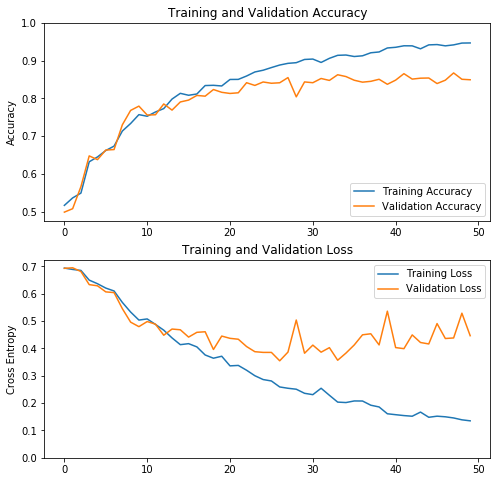

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### 保存模型

In [19]:
model.save("base_mode.h5")

### 在测试图像上应用模型

In [20]:
class_names = {1:'狗', 0:'猫'}  

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [22]:
test_f = load_img("test/dog.jpg", target_size=(image_size, image_size))
test_f = img_to_array(test_f)
test_f = np.expand_dims(test_f,axis=0)
test_f = test_f / 225.

In [23]:
pred = model.predict(test_f)
print(pred)

[[0.9996722]]


In [24]:
result = class_names[0] if pred[0]<0.5 else class_names[1] 
print("预测结果是： %s" %result)

预测结果是： 狗


### CNN的可视化
* 可视化特征图
   * 给定输入，展示网络中各个卷积层和池化层的激活函数的输出。

In [25]:
model.summary()

Model: "CNN_CAT_DOG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       

#### 预处理单张图片

In [27]:
test_f = load_img("test/dog.jpg", target_size=(image_size, image_size))
test_f = img_to_array(test_f)
test_f = np.expand_dims(test_f,axis=0)
test_f = test_f / 225.
print(test_f.shape)

(1, 160, 160, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


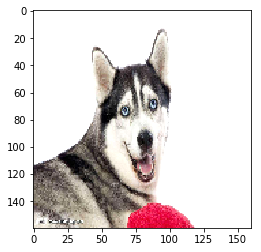

In [29]:
import matplotlib.pyplot as plt
plt.imshow(test_f[0])
plt.show()

#### 截取模型

In [30]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[0:10]]
activation_model = models.Model(inputs=model.input,outputs=layer_outputs)

#### 以预测模式运行模型
* 与model.summary()对应层输出一致

In [36]:
activations = activation_model.predict(test_f)
for i in range(len(activations)):
    print(activations[i].shape)


(1, 158, 158, 32)
(1, 79, 79, 32)
(1, 77, 77, 64)
(1, 38, 38, 64)
(1, 36, 36, 64)
(1, 18, 18, 64)
(1, 16, 16, 128)
(1, 8, 8, 128)
(1, 6, 6, 128)
(1, 3, 3, 128)


#### 第一层第3个通道可视化

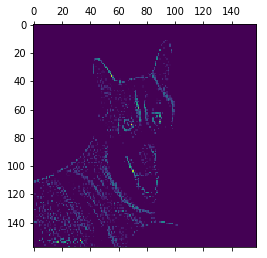

In [40]:
import matplotlib.pyplot as plt
plt.matshow(activations[0][0,:,:,3], cmap='viridis')

#### 第一层第10个通道可视化

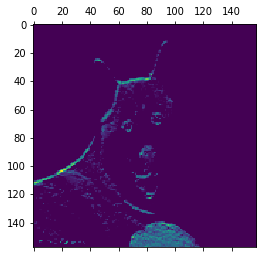

In [45]:
import matplotlib.pyplot as plt
plt.matshow(activations[0][0,:,:,10], cmap='viridis')

#### 第5层的所有通道可视化

/home/iniesa/workspace/venv/tensorflow_2.0.0/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


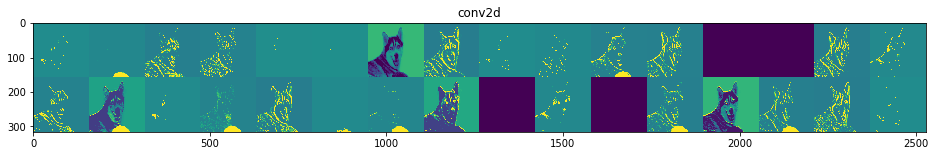

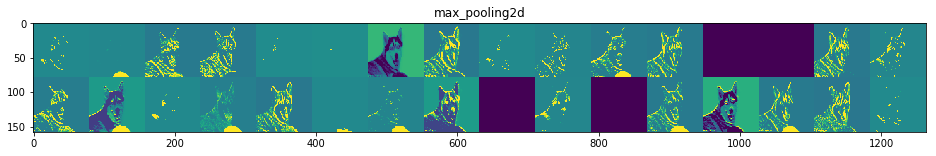

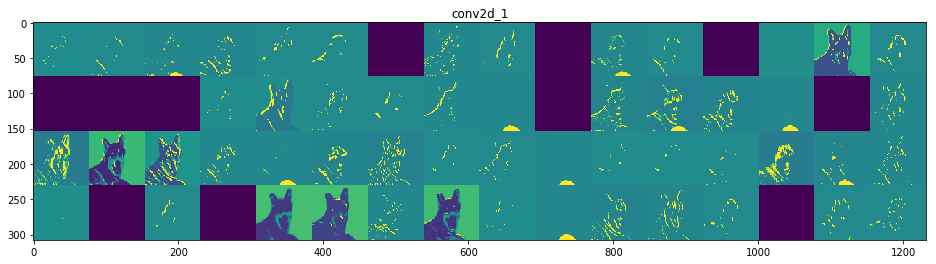

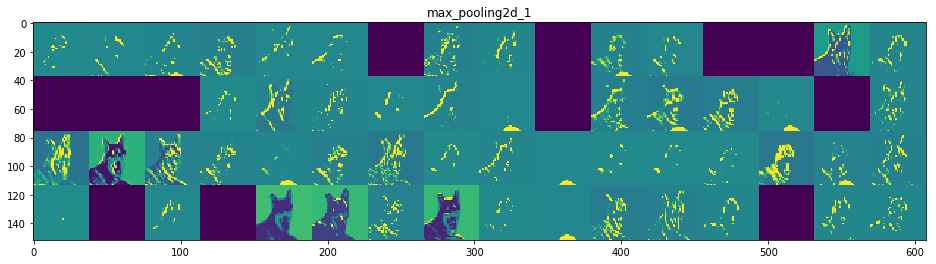

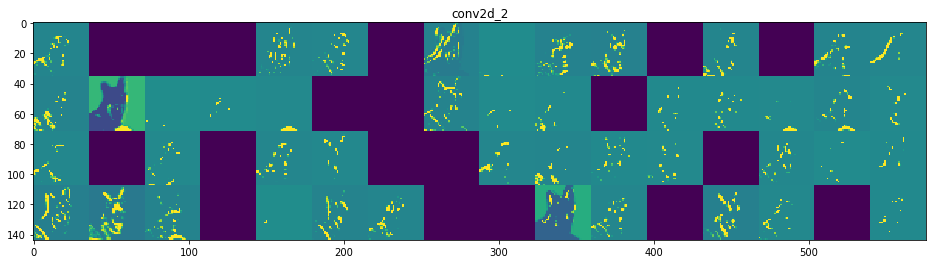

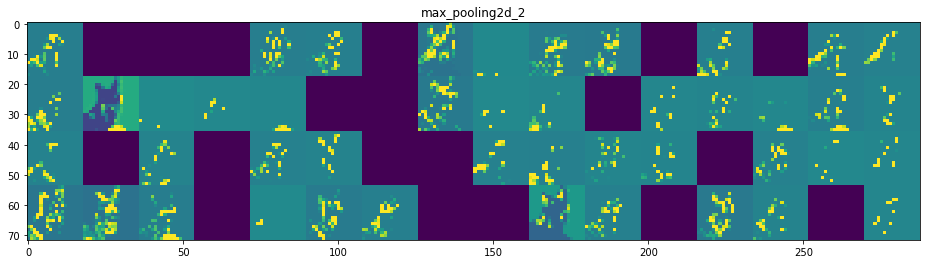

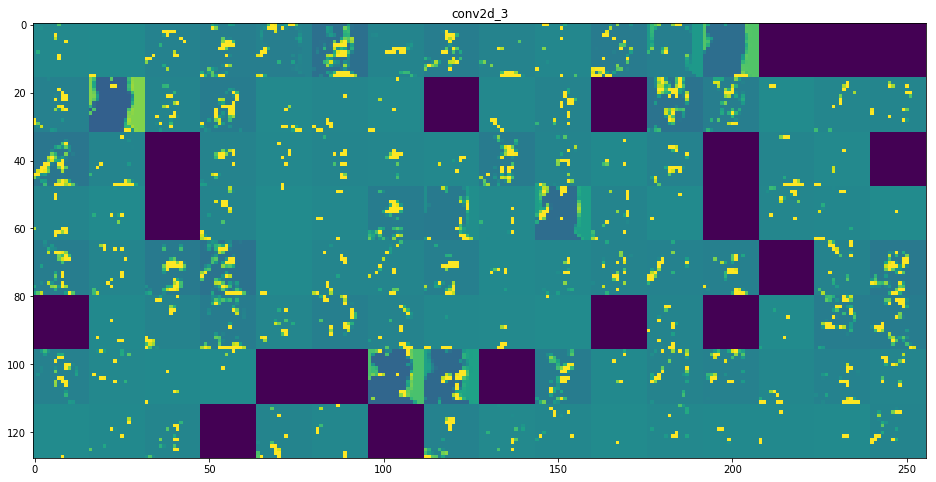

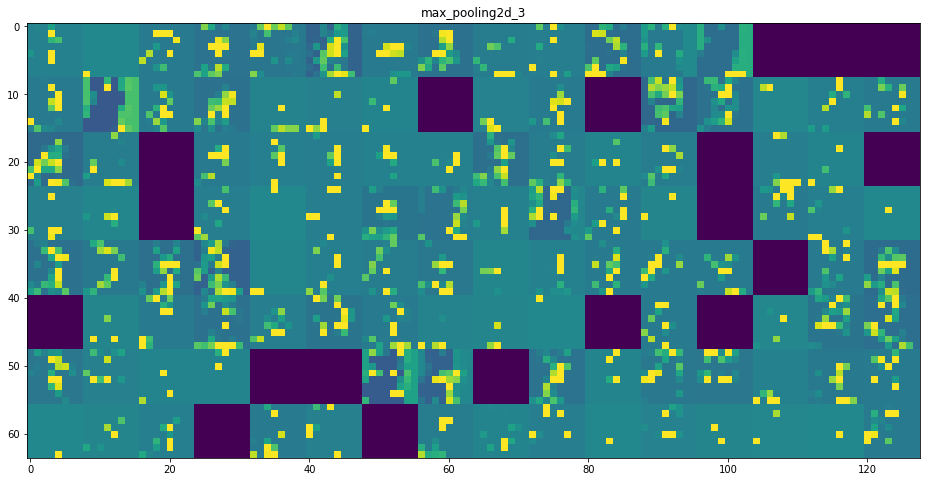

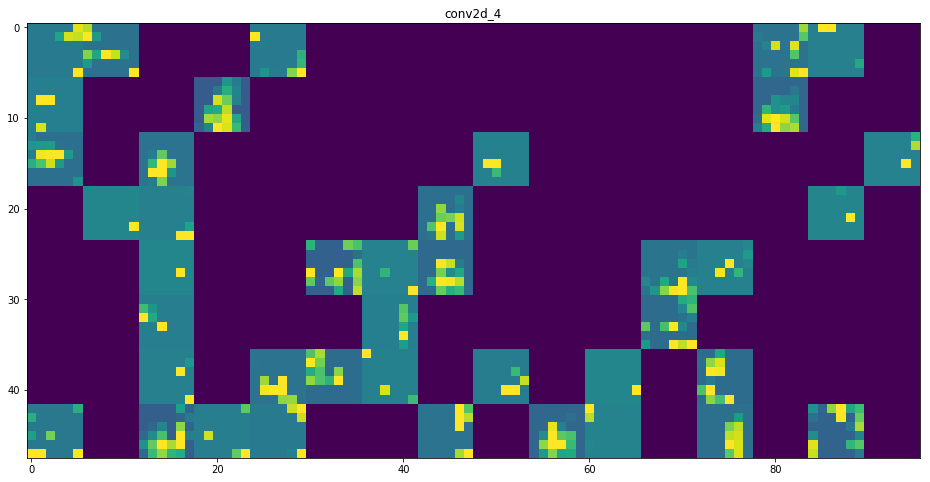

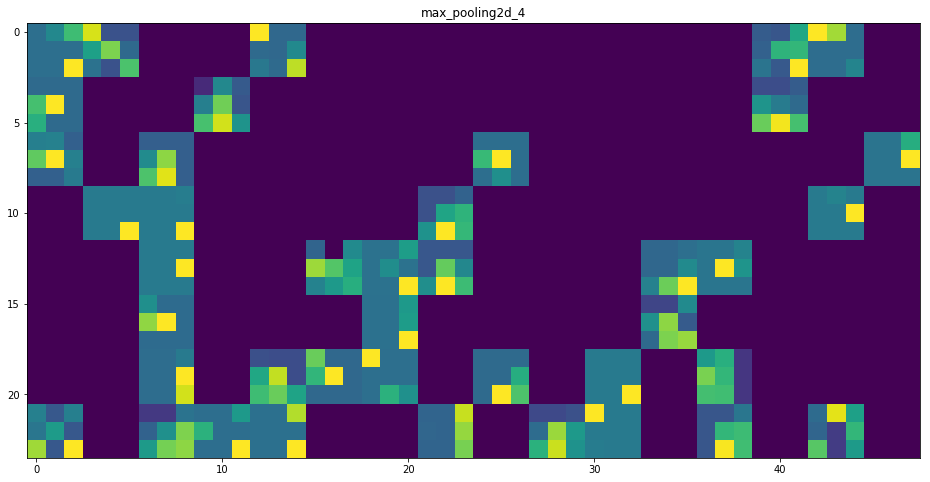

In [47]:
#%% 就每个中间激活的所有通道可视化
layer_names = [] #利用循环得到前8层的名称
for layer in model.layers[: 10]:
    layer_names.append(layer.name)
images_per_row = 16 #规定输出结果中每行特征图的个数
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] #特征图中特征的个数
    size = layer_activation.shape[1] #特征图形状(1, size, size, n_features)
    n_cols = n_features // images_per_row #决定输出结果列数
    # 建立空的输出结果图用于显示所以特征图
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): #对输出图逐列循环绘制
        for row in range(images_per_row): #逐行遍历逐个子图
            channel_image = layer_activation[0, :, :,
                col * images_per_row + row]
            # 对特征图进行数据处理优化显示效果
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            # 图像数组取阈值避免出现不合理值
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # 在结果网格中显示图片
            display_grid[col * size : (col + 1) * size,
                row * size : (row + 1) * size] = channel_image
    scale = 1. / size #确定特征图缩放比例
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

### 思考：如何再优化呢？
